In [1]:
!pip install -q transformers datasets segments-ai evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 33.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.7 MB/s eta 0:00:00


In [2]:
from transformers import BeitFeatureExtractor, BeitForSemanticSegmentation
from datasets import load_dataset
import torch
from matplotlib import pyplot as plt
import numpy as np
import random

In [3]:
train_ds = load_dataset("scene_parse_150")
train_ds = train_ds['train'].shuffle(seed=1)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20210 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3352 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset scene_parse_150 downloaded and prepared to /root/.cache/huggingface/datasets/scene_parse_150/scene_parsing/1.0.0/d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
model_name = "microsoft/beit-base-finetuned-ade-640-640"
feature_extractor = BeitFeatureExtractor(do_resize=True, size=640, do_center_crop=False)
model = BeitForSemanticSegmentation.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/900M [00:00<?, ?B/s]

BeitForSemanticSegmentation(
  (beit): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): BeitPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relative_position_bias): BeitRelativePositionBias()
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (in

In [5]:
train_ds.shape[0]

20210

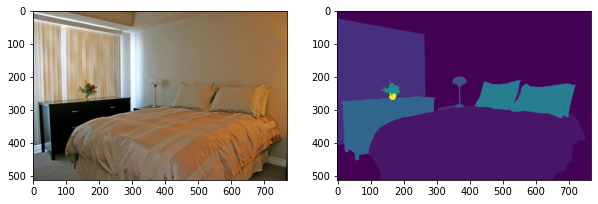

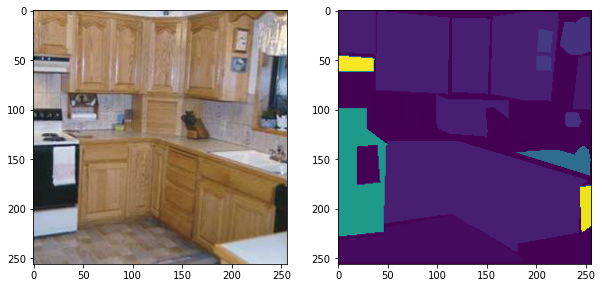

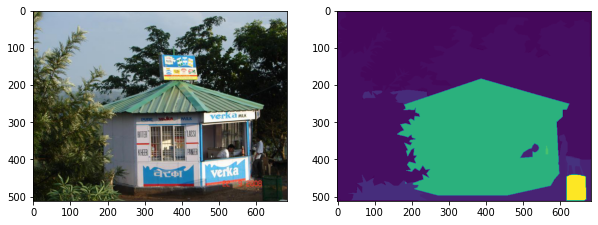

In [6]:
random_image = []
for _ in range(3):
 random_image.append(random.randint(0, train_ds.shape[0]))

for i in random_image:
  fig, axs = plt.subplots(1, 2, figsize=(10, 10))
  axs[0].imshow(train_ds[i]['image'])
  axs[1].imshow(train_ds[i]['annotation'])

In [7]:
def segment(img):
  feature = feature_extractor(img, return_tensors="pt")
  pixels = feature.pixel_values
  outputs = model(pixel_values=pixels.cuda())
  logits = outputs.logits
  upsampled_logits = torch.nn.functional.interpolate(logits, size=img.size[::-1], mode="bilinear", align_corners=False )
  pred = upsampled_logits.argmax(dim=1)[0]
  return pred

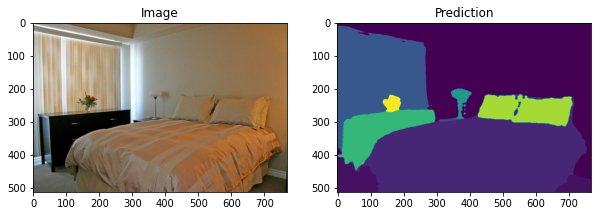

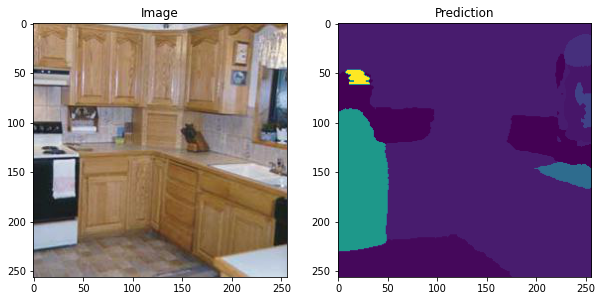

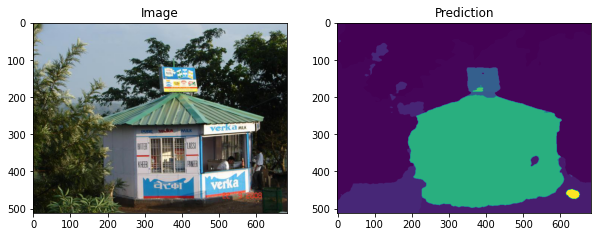

In [9]:
for i in random_image:
  pred = segment(train_ds[i]['image'])
  fig, axs = plt.subplots(1, 2, figsize=(10, 10))
  axs[0].imshow(train_ds[i]['image'])
  axs[0].set_title('Image')
  axs[1].imshow(pred.cpu())
  axs[1].set_title('Prediction')